TREINAMENTO DO MODELO DE DETECÇÃO DE LETRAS EM LIBAS

In [25]:
# IMPORT
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from kerastuner.tuners import RandomSearch

In [26]:
# Parâmetros
IMG_SIZE = 32
BATCH_SIZE = 32
EPOCHS = 50
DATASET_DIR = "../dataset"

# Data Augmentation + Normalização
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=False
)

# Dados de treino
train_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)


# Dados de validação
val_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Mapeamento das classes (letras)
class_indices = train_generator.class_indices
print("Mapeamento das classes:", class_indices)

Found 5919 images belonging to 21 classes.
Found 1472 images belonging to 21 classes.
Mapeamento das classes: {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'i': 7, 'l': 8, 'm': 9, 'n': 10, 'o': 11, 'p': 12, 'q': 13, 'r': 14, 's': 15, 't': 16, 'u': 17, 'v': 18, 'w': 19, 'y': 20}


In [27]:
# Salvar mapeamento para uso posterior
import json
with open('../models/class_indices.json', 'w') as f:
    json.dump(class_indices, f)

In [28]:
# Modelo CNN aprimorado
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 21)             │         2,709 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,621 (631.33 KB)

 Trainable params: 161,621 (631.33 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
#Hiperparâmetros
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Choice('conv_1_filter', values=[32, 64, 128]),
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=(32, 32, 3)
    ))
    model.add(tf.keras.layers.MaxPooling2D(2, 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=32),
        activation='relu'
    ))
    model.add(tf.keras.layers.Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

num_classes = train_generator.num_classes

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='tuning_results',
    project_name='asl_libras'
)

tuner.search(train_generator, epochs=10, validation_data=val_generator)

# Pega o melhor modelo
best_model = tuner.get_best_models(num_models=1)[0]

Reloading Tuner from tuning_results\asl_libras\tuner0.json


Epoch 1/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9643 - loss: 0.1121
Epoch 1: val_loss improved from inf to 0.24491, saving model to ../models/best_model.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.9643 - loss: 0.1121 - val_accuracy: 0.9280 - val_loss: 0.2449
Epoch 2/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9709 - loss: 0.0932
Epoch 2: val_loss improved from 0.24491 to 0.21318, saving model to ../models/best_model.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.9709 - loss: 0.0934 - val_accuracy: 0.9361 - val_loss: 0.2132
Epoch 3/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9675 - loss: 0.0929
Epoch 3: val_loss did not improve from 0.21318
185/185 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.9675 - loss: 0.0930 - val_accuracy: 0.9293 - val_loss: 0.2375
Epoch 4/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9712 - loss: 0.0970
Epoch 4: val_loss did not improve from 0.21318
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.9712 - loss: 0.0970 - val_accuracy: 0.9253 - val_loss: 0.2371
Epoch 5/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9625 - loss: 0.1144
Epoch 5: val_loss did not improve from 0.21318
185/185 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.9625 - loss: 0.1143 - val_accuracy: 0.9287 - val_loss: 0.2343
Epoch 6/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9658 - loss: 0.0995
Epoch 6: val_loss did not improve f

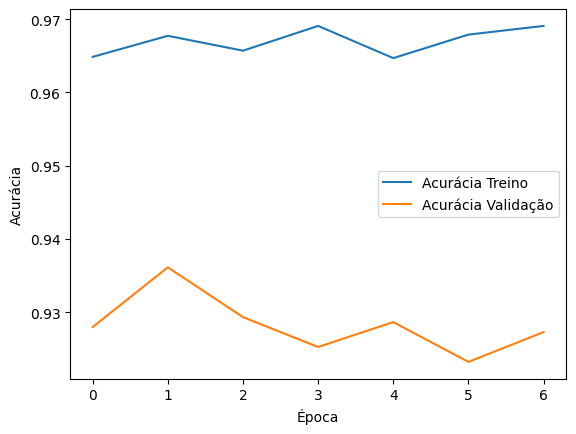

In [30]:
# Treinamento com early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint(
    filepath='../models/best_model.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

history = best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint]
)

# Plot dos resultados
plt.plot(history.history['accuracy'], label='Acurácia Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

In [31]:
# Salva o modelo treinado
best_model.save('../models/asl_gesture_model2.h5')
print("Modelo salvo como 'asl_gesture_model2.h5'")

Modelo salvo como 'asl_gesture_model2.h5'
